In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples

#k-means uygulayacağım verisetime eriştim.
df = pd.read_excel("DATASET_LASTFORM.xlsx")

In [ ]:
#Kullanacağım sütunlar
kmeans_columns = ['durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
                  'transferDuration', 'totalDuration', 'throughput']

#NaN olanları sildim.
df_kmeans = df[kmeans_columns].dropna()

#standardize ettim.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_kmeans)

#Veri boyutuna göre dinamik k aralığı belirlenmesi
max_k = min(10, len(df_kmeans) - 1)
k_range = range(2, max_k + 1)

#Listeler
inertia_values = [] #Küme içindeki verilerin merkeze olan uzaklıklarının toplamı.(düşük olması iyi)
silhouette_scores = [] #Verinin kümelere ne kadar “iyi” ayrıldığını ölçen bir metrik. 1’e ne kadar yakınsa, kümeler o kadar ayrışmıştır.

# K-means döngüsü
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(scaled_data)

    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_).item())

#En iyi k (küme sayısı)
best_k = k_range[np.argmax(silhouette_scores)]

print("Inertia Values:", inertia_values)
print("Silhouette Scores:", silhouette_scores)
print("En iyi küme sayısı (k):", best_k)

#k-means algoritması uygulayıp inertia, silhouette değerlerini ve k değerini buldum.

Inertia Values: [3699.266666548761, 2771.136541410553, 2047.773781974994, 1610.6479411215698, 1344.6201966274025, 1124.1052545466189, 910.3046414696367, 736.1371786104212, 665.4913106129861]
Silhouette Scores: [0.6440083767376474, 0.6587078107024312, 0.6781779321911877, 0.5817729078912559, 0.620055962515172, 0.6206627723508011, 0.6042016537164521, 0.6074329176561777, 0.6049733349819792]
En iyi küme sayısı (k): 4


In [ ]:
#Başlangıç değerleri
best_overall_score = -1
best_state = None
best_k = None
best_model = None

#K değerini veri sayısına göre dinamik ayarlıyorum.
max_k = min(10, len(df_kmeans) - 1)
k_range = range(2, max_k + 1)

#Her k değeri için 0'dan 9'a kadar farklı random_state değerlerini deniyorum.
for k in k_range:
    for state in range(0, 10):
        kmeans = KMeans(n_clusters=k, random_state=state, n_init=10)
        kmeans.fit(scaled_data)
        score = silhouette_score(scaled_data, kmeans.labels_)

#Skor, şimdiye kadarki en yüksek skordan büyükse güncelleme yapılıyor.
        if score > best_overall_score:
            best_overall_score = score
            best_state = state
            best_k = k
            best_model = kmeans

#sonuçları yazdırıyorum.
print(f"En iyi küme sayısı (k): {best_k}")
print(f"En iyi random_state: {best_state}")
print(f"En yüksek Silhouette skoru: {best_overall_score:.4f}")

#k , random_state ve silhouette skoru için en iyisini buldum.

En iyi küme sayısı (k): 4
En iyi random_state: 8
En yüksek Silhouette skoru: 0.6800


In [ ]:
#KMeans modeli (k=4) ile eğitimi
kmeans = KMeans(n_clusters=4, random_state=8, n_init=10)
kmeans.fit(scaled_data)

#Küme etiketlerini veriye ekledim.
df_kmeans['cluster'] = kmeans.labels_

#Küme merkezlerini yazdırıyorum.
print("Küme Merkezleri (ölçeklenmiş uzayda):")
print(kmeans.cluster_centers_)

#Her kümeden 5 örnek yazdırdım.
for cluster_id in sorted(df_kmeans['cluster'].unique()):
    print(f"\nKüme {cluster_id}'den Örnekler:")
    print(df_kmeans[df_kmeans['cluster'] == cluster_id].head(5)[kmeans_columns + ['cluster']])

#kümelerden örnekler yazdırıp inceliyorum.

Küme Merkezleri (ölçeklenmiş uzayda):
[[-6.78662508e-01 -8.14235390e-01 -8.18710392e-01 -8.18289332e-01
  -1.60709160e-01 -8.14146584e-01 -1.56817210e-01]
 [ 8.46464814e-01  1.01077957e+00  1.05309579e+00  1.05280172e+00
   6.72139348e-03  1.01063382e+00 -1.44326327e-01]
 [-8.44230401e-01 -9.75391350e-01 -9.69308634e-01 -9.71927693e-01
  -2.07813678e-01 -9.76371243e-01  4.49137374e+00]
 [ 1.51630270e+00  1.91085192e+00  4.66942614e-01  4.64895904e-01
   7.89252522e+00  1.91473640e+00  1.81818283e+00]]

Küme 0'den Örnekler:
   durationInMs  copyDuration  durationInQueue  queueDuration  \
0         45076            41               13             12   
1         52344            47               29             28   
2         42686            39                0             12   
3         46733            43                0              9   
4         37801            34                0             10   

   transferDuration  totalDuration  throughput  cluster  
0                19   

In [ ]:
#Her kümede kaç örnek olduğunu gösteriyorum.
print("\nHer Kümede Kaç Örnek Var:")
print(df_kmeans['cluster'].value_counts())

#Yüzde olarak dağılımı gösteriyorum.
print("\nKüme Dağılımı (Yüzde):")
print((df_kmeans['cluster'].value_counts(normalize=True) * 100).round(2))

#Hangi kümenin daha kalabalık olduğunu veriyor.
most_common_cluster = df_kmeans['cluster'].value_counts().idxmax()
print(f"\nKüme {most_common_cluster} en kalabalık.")



Her Kümede Kaç Örnek Var:
cluster
0    665
1    543
2     35
3     14
Name: count, dtype: int64

Küme Dağılımı (Yüzde):
cluster
0    52.90
1    43.20
2     2.78
3     1.11
Name: proportion, dtype: float64

Küme 0 en kalabalık.


In [ ]:
#k=4 iken performans metrikleri
kmeans_4 = KMeans(n_clusters=4, random_state=8, n_init=10)
kmeans_4.fit(scaled_data)
labels_4 = kmeans_4.labels_

print("K=4 için metrikler:")
silhouette_4 = silhouette_score(scaled_data, labels_4)
ch_score_4 = calinski_harabasz_score(scaled_data, labels_4)
db_score_4 = davies_bouldin_score(scaled_data, labels_4)

print(f"Silhouette Score: {silhouette_4:.4f}")
print(f"Calinski-Harabasz Score: {ch_score_4:.2f}") #Yüksek değer daha iyi (kümeler arası ayrışma / kümeler içi tutarlılık)
print(f"Davies-Bouldin Score: {db_score_4:.4f}") #Küçük değerler daha iyi (kümeler arası benzerlik / ayrışma ölçütü)

cluster_df_4 = pd.DataFrame({'cluster': labels_4})
cluster_counts_4 = cluster_df_4['cluster'].value_counts(normalize=True)

#silhouette skoru 0.5 ' ten düşükse kümeler net ayrışmamış.
if silhouette_4 < 0.5:
    print("Silhouette skoru düşük; kümeler net ayrışmamış olabilir.")

#eğer verinin %50'den fazlası bir kümede biriktiyse yığılma var demektir.
if cluster_counts_4.max() > 0.5:
    print("Bir kümeye aşırı yığılma var.")
else:
    print("Kümeler dengeli ve iyi ayrışmış.")

K=4 için metrikler:
Silhouette Score: 0.6800
Calinski-Harabasz Score: 1376.37
Davies-Bouldin Score: 0.6471
Bir kümeye aşırı yığılma var.


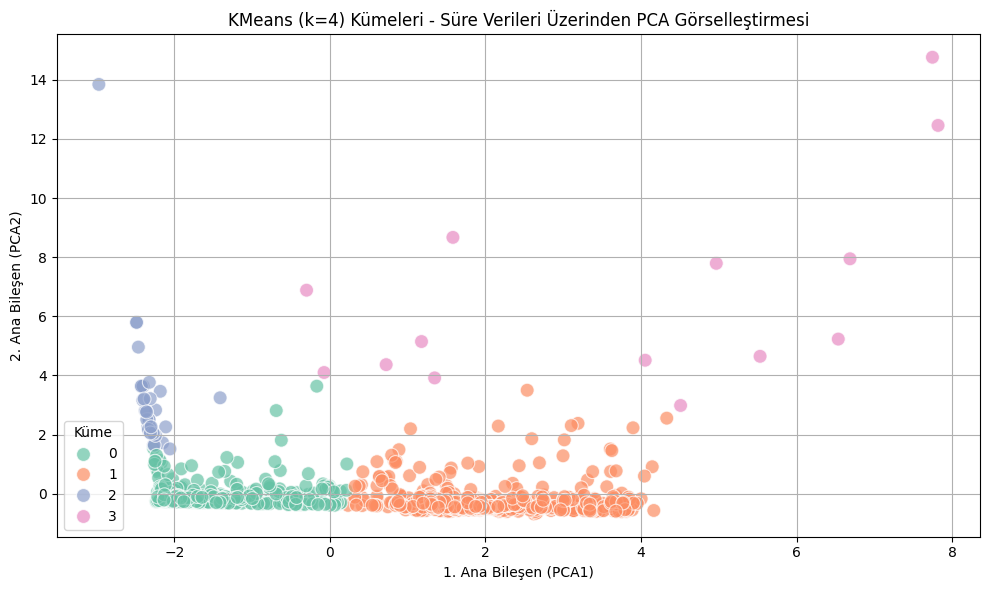

In [ ]:
# PCA: 7 boyutlu scaled_data'yı 2 boyuta indiriyorum.
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

#Sonuçları DataFrame'e çevirdim.
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = best_model.labels_

#Görselleştirme
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='Set2', s=100, alpha=0.7)

plt.title('KMeans (k={}) Kümeleri - Süre Verileri Üzerinden PCA Görselleştirmesi'.format(best_model.n_clusters))
plt.xlabel('1. Ana Bileşen (PCA1)')
plt.ylabel('2. Ana Bileşen (PCA2)')
plt.legend(title='Küme')
plt.grid(True)
plt.tight_layout()
plt.show()

#kümelerin nasıl dağıldığını şekilde inceleyebiliyorum.

In [ ]:
#Hedef sütunlar
duration_columns = ['durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
                    'transferDuration', 'totalDuration', 'throughput']

#Her sütun için ayrı ayrı kümeleme yapıyorum.
for col in duration_columns:
    #NaN varsa satırı çıkarsın.
    valid_rows = df[[col]].dropna()

    #Log dönüşümü ve ölçekleme (negatif riskine karşı log1p)
    log_col = np.log1p(valid_rows[col])
    scaler = StandardScaler()
    scaled_col = scaler.fit_transform(log_col.values.reshape(-1, 1))

    #KMeans ile 3 kümeye ayırıyorum.
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
    kmeans.fit(scaled_col)

    #Küme etiketlerini DataFrame'e geri ekledim.
    cluster_labels = kmeans.labels_
    temp = valid_rows.copy()
    temp[f'{col}_cluster'] = cluster_labels

    #Küme merkezlerine göre küçükten büyüğe sıralayıp etiketleri hizalama
    centers = kmeans.cluster_centers_.flatten()
    sorted_idx = np.argsort(centers)
    label_map = {sorted_idx[0]: 0, sorted_idx[1]: 1, sorted_idx[2]: 2}  # 0: kısa, 1: orta, 2: uzun
    temp[f'{col}_cluster_numeric'] = temp[f'{col}_cluster'].map(label_map)

    #Etiketlerle etiketleme
    label_names = {0: 'Kısa Süre', 1: 'Orta Süre', 2: 'Uzun Süre'}
    temp[f'{col}_cluster_label'] = temp[f'{col}_cluster_numeric'].map(label_names)

    #Ana df’ye geri aktardım. (sadece o sütunlara)
    df.loc[temp.index, f'{col}_cluster'] = temp[f'{col}_cluster']
    df.loc[temp.index, f'{col}_cluster_numeric'] = temp[f'{col}_cluster_numeric']
    df.loc[temp.index, f'{col}_cluster_label'] = temp[f'{col}_cluster_label']

#küme dağılımı ve örnekler
for col in duration_columns:
    print(f"{col} küme dağılımı:")
    print(df[f'{col}_cluster_label'].value_counts())

    print(f"{col} örnekler:")
    print(df[[col, f'{col}_cluster_label']].dropna().head(5))

#Her bir süre sütununu ayrı ayrı ele alarak 3 kümeye ayırdım ve her değeri “Kısa”, “Orta” ya da “Uzun” süre olarak etiketledim. Bu sayede süreleri kategorik olarak sınıflandırmış oldum.

durationInMs küme dağılımı:
durationInMs_cluster_label
Uzun Süre    646
Orta Süre    527
Kısa Süre     84
Name: count, dtype: int64
durationInMs örnekler:
   durationInMs durationInMs_cluster_label
0         45076                  Orta Süre
1         52344                  Orta Süre
2         42686                  Orta Süre
3         46733                  Orta Süre
4         37801                  Orta Süre
copyDuration küme dağılımı:
copyDuration_cluster_label
Uzun Süre    612
Kısa Süre    421
Orta Süre    224
Name: count, dtype: int64
copyDuration örnekler:
   copyDuration copyDuration_cluster_label
0            41                  Kısa Süre
1            47                  Kısa Süre
2            39                  Kısa Süre
3            43                  Kısa Süre
4            34                  Kısa Süre
durationInQueue küme dağılımı:
durationInQueue_cluster_label
Uzun Süre    628
Kısa Süre    410
Orta Süre    219
Name: count, dtype: int64
durationInQueue örnekler:
   duratio

In [ ]:
duration_columns = ['durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
                    'transferDuration', 'totalDuration', 'throughput']

print("\nHer Süre Sütunu için Küme Örnek Sayısı ve Yüzdeleri:")

#Her süre sütunu için döngü
for col in duration_columns:
    col_numeric = f'{col}_cluster_numeric'
    col_label = f'{col}_cluster_label'

#Eğer ilgili sütunlar DataFrame'de varsa her kümede kaç örnek olduğunu alacak ve yüzde olarak dağılımını hesaplayacak.
    if col_numeric in df.columns and col_label in df.columns:
        cluster_counts = df[col_numeric].value_counts(normalize=False).sort_index()
        cluster_percent = df[col_numeric].value_counts(normalize=True).sort_index() * 100

 # Her küme (0: kısa, 1: orta, 2: uzun) için
        print(f"\n>>> {col} Küme Dağılımı:")
        for i in [0, 1, 2]:
            # Eğer o cluster indexinde değer yoksa hata vermesin diye kontrol yapıyorum.
            if i in cluster_counts.index:
                label = df[df[col_numeric] == i][col_label].iloc[0]
                count = cluster_counts[i]
                percent = cluster_percent[i]
                print(f"Küme {i} ({label}): {count} adet ({percent:.2f}%)")
            else:
                print(f"Küme {i}: Veri yok")
    else:
        print(f"{col} için küme sütunları bulunamadı.")

#Her bir süre sütunu için, 3 kümeye (Kısa, Orta, Uzun) ayrılan değerlerin hem adet hem de yüzde olarak dağılımını hesapladım ve yazdırdım.


Her Süre Sütunu için Küme Örnek Sayısı ve Yüzdeleri:

>>> durationInMs Küme Dağılımı:
Küme 0 (Kısa Süre): 84 adet (6.68%)
Küme 1 (Orta Süre): 527 adet (41.93%)
Küme 2 (Uzun Süre): 646 adet (51.39%)

>>> copyDuration Küme Dağılımı:
Küme 0 (Kısa Süre): 421 adet (33.49%)
Küme 1 (Orta Süre): 224 adet (17.82%)
Küme 2 (Uzun Süre): 612 adet (48.69%)

>>> durationInQueue Küme Dağılımı:
Küme 0 (Kısa Süre): 410 adet (32.62%)
Küme 1 (Orta Süre): 219 adet (17.42%)
Küme 2 (Uzun Süre): 628 adet (49.96%)

>>> queueDuration Küme Dağılımı:
Küme 0 (Kısa Süre): 417 adet (33.17%)
Küme 1 (Orta Süre): 219 adet (17.42%)
Küme 2 (Uzun Süre): 621 adet (49.40%)

>>> transferDuration Küme Dağılımı:
Küme 0 (Kısa Süre): 406 adet (32.30%)
Küme 1 (Orta Süre): 552 adet (43.91%)
Küme 2 (Uzun Süre): 299 adet (23.79%)

>>> totalDuration Küme Dağılımı:
Küme 0 (Kısa Süre): 418 adet (33.25%)
Küme 1 (Orta Süre): 220 adet (17.50%)
Küme 2 (Uzun Süre): 619 adet (49.24%)

>>> throughput Küme Dağılımı:
Küme 0 (Kısa Süre): 870 ad

In [ ]:
#k=3 iken performans metrikleri
kmeans_3 = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_3.fit(scaled_data)
labels_3 = kmeans_3.labels_

print("K=3 için metrikler:")
silhouette_3 = silhouette_score(scaled_data, labels_3)
ch_score_3 = calinski_harabasz_score(scaled_data, labels_3)
db_score_3 = davies_bouldin_score(scaled_data, labels_3)

print(f"Silhouette Score: {silhouette_3:.4f}")
print(f"Calinski-Harabasz Score: {ch_score_3:.2f}")
print(f"Davies-Bouldin Score: {db_score_3:.4f}")

cluster_df_3 = pd.DataFrame({'cluster': labels_3})
cluster_counts_3 = cluster_df_3['cluster'].value_counts(normalize=True)

if silhouette_3 < 0.5:
    print("Silhouette skoru düşük; kümeler net ayrışmamış olabilir.")
if cluster_counts_3.max() > 0.6:
    print("Bir kümeye aşırı yığılma var.")
else:
    print("Kümeler dengeli ve iyi ayrışmış.")


K=3 için metrikler:
Silhouette Score: 0.6587
Calinski-Harabasz Score: 1363.87
Davies-Bouldin Score: 0.6622
Kümeler dengeli ve iyi ayrışmış.


Ortalama Silhouette Skoru: 0.6587


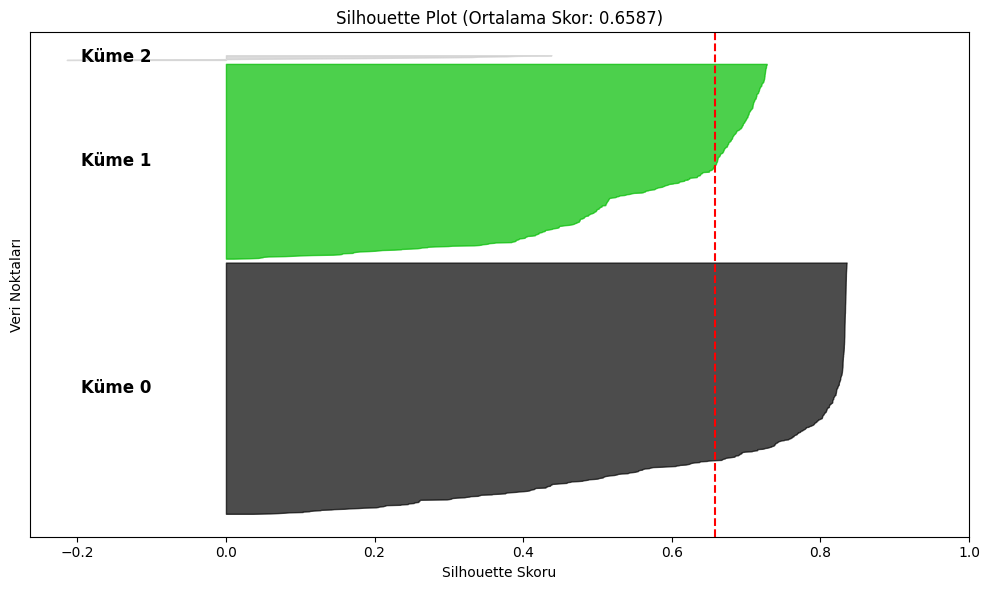

In [ ]:
#Ölçeklenmiş 7 sütunlu veri: scaled_data
#KMeans ile 3 kümeye ayırma
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans.fit(scaled_data)
labels = kmeans.labels_

#Ortalama Silhouette Skoru
silhouette_avg = silhouette_score(scaled_data, labels)
print(f"Ortalama Silhouette Skoru: {silhouette_avg:.4f}")

#Her nokta için Silhouette skorları
silhouette_vals = silhouette_samples(scaled_data, labels)

#Silhouette Plot
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
n_clusters = 3
colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_clusters))

for i, color in zip(range(n_clusters), colors):
    # O küme için silhouette skorlarını al ve sırala
    cluster_vals = silhouette_vals[labels == i]
    cluster_vals.sort()

    size = len(cluster_vals)
    y_upper = y_lower + size

    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(-0.1, (y_lower + y_upper) / 2, f"Küme {i}", va='center', ha='right',
            fontsize=12, fontweight='bold')

    y_lower = y_upper + 10

#Ortalama skoru gösteren çizgi
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

#Eksen ayarları
ax.set_title(f"Silhouette Plot (Ortalama Skor: {silhouette_avg:.4f})")
ax.set_xlabel("Silhouette Skoru")
ax.set_ylabel("Veri Noktaları")
ax.set_yticks([])
ax.set_xlim([silhouette_vals.min() - 0.05, 1])

plt.tight_layout()
plt.show()

#Kırmızı çizgiyle gösterilen ortalama silhouette skoruna göre kümelerin ayrışma kalitesini değerlendirdim.